# Содержание
1. [Загрузка и подготовка данных](#start)
    * [Обзор данных](#info)
    * [Предобработка данных](#preprocessing)
    * [Предварительный анализ](#initial_analysis)
    * [Вывод](#result_1)
2. [Обучение и проверка модели](#model_fit)
    * [Вывод](#result_2)
3. [Подготовка к расчёту прибыли](#Preparing_calculation)
    * [Сохранение всех ключевых значений для расчётов в отдельные переменные](#var)
    * [Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение.](#calc)
    * [Вывод](#result_3)
4. [Расчёт прибыли и рисков](#profit)
    * [Функция рассчета прибыли](#def_profit)
    * [Расчёт](#profit_loss)
    * [Вывод](#result_4)
5. [Подведение итогов](#result)

# 1. Загрузка и подготовка данных <a id="start"></a>



Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv.
- geo_data_1.csv. 
- geo_data_2.csv.
---
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

---

In [2]:
dataset = ['./datasets/geo_data_0.csv', 
           './datasets/geo_data_1.csv', 
           './datasets/geo_data_2.csv']

# словарь с парами 'имя_таблицы:DataFrame' для удобства итерации по датафреймам. позже вынести в глобальные
geo_data = {}

# Функция читате файл csv
def read_files(name_df, file): 
    try:
        name_df = pd.read_csv(file)
    except:
        print('Не удалось прочитать', file, 'проверьте расположение файла')
    return name_df
# Функция разбирает пути из списка, выделяет из каждого имя файла и записывает в индекс словаря: имя 
# а результат работы функции read_files в значение 
def read_files_get_list(files):
    for file in files:
        only_file_name = file.split("/")[-1][0:-4]
        geo_data[only_file_name] = read_files(only_file_name, file)

read_files_get_list(dataset)

## Обзор данных. <a id="info"></a>

In [3]:
# Общая информация
for name, data in geo_data.items():
    print('=='*5, 'Info по' , name, '=='*5)
    print('')
    data.info()
    print('')

========== Info по geo_data_0 ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

========== Info по geo_data_1 ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

========== Info по geo_data_2 ==========

<cla

In [4]:
# Смотрим данные
for name, data in geo_data.items():
    print('=='*7, 'Таблица', name, '=='*7)
    display(data.head(5))

============== Таблица geo_data_0 ==============


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


============== Таблица geo_data_1 ==============


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


============== Таблица geo_data_2 ==============


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


## Предварительный анализ. <a id="initial_analysis"></a>

geo_data_0


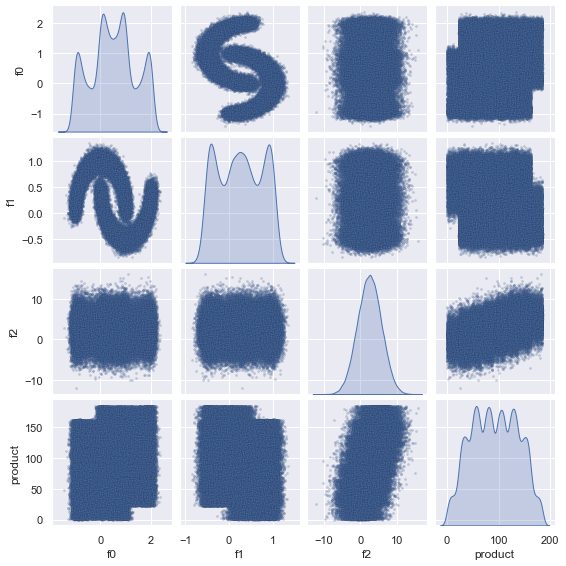

geo_data_1


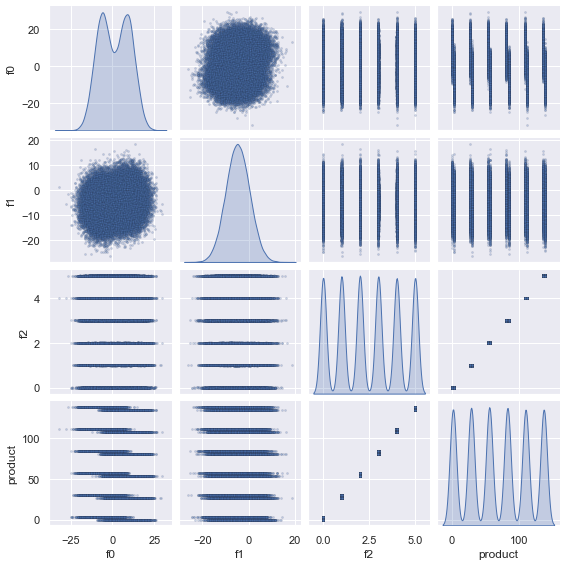

geo_data_2


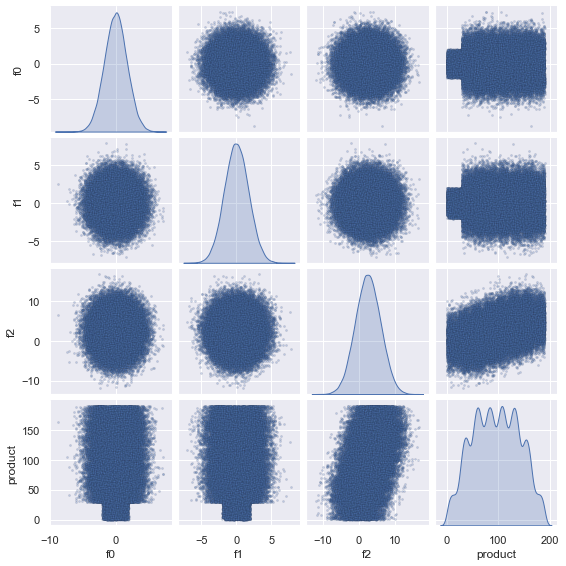

In [5]:
# Попарные отношения в наборе данных
for name, data in geo_data.items():
    print(name)
    sns.pairplot(data, diag_kind = 'kde',
             plot_kws = {'alpha': 0.3, 's': 5, 'edgecolor': 'k'},
             height = 2)
    plt.show()


Во втором регионе признак `f2` хорошо определяет `product`.

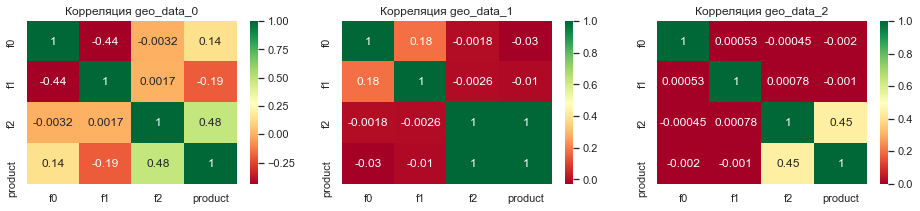

In [6]:
# Корреляция к целевому признаку
plt.figure(figsize=(16,3))
i = 0
for name, data in geo_data.items():
    plt.subplot(1,len(geo_data),i+1)
    plt.title('Корреляция '+ name)
    sns.heatmap(data.corr(), cmap='RdYlGn', annot=True)
    i+=1
plt.show()

Во всех данных к объему запасов скважин коррелирует признак f2. В geo_data_1 прямая зависимость.

<AxesSubplot:>

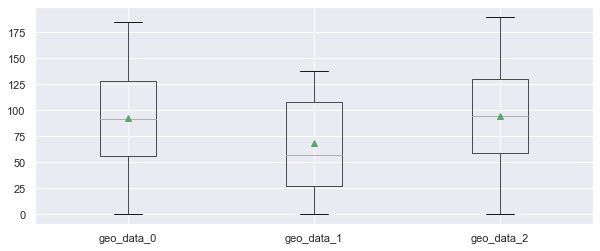

In [7]:
# Разброс запасов сырья
product = pd.DataFrame()
for name, data in geo_data.items():
    product[name] = data['product']
product.boxplot( showmeans = True , figsize = (10, 4))

Распределения целевого признака близки к нормальному

## Предварительная обработка данных<a id="preprocessing"></a>

In [8]:
# Пропуски
for name, data in geo_data.items():
    print('--', 'Пропуски в', name, '--')
    display(data.isnull().sum())

-- Пропуски в geo_data_0 --


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

-- Пропуски в geo_data_1 --


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

-- Пропуски в geo_data_2 --


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Смотрим уникальность скважин. Возможно это категориальный признак.

In [9]:

id = pd.DataFrame()
for name, data in geo_data.items():
    id[name] = data['id']
    
id.nunique()

geo_data_0    99990
geo_data_1    99996
geo_data_2    99996
dtype: int64

Id скважин почти все разные. Не являются категориальными признаками. Можно отбросить эти данные.

In [10]:
for name, data in geo_data.items():
    geo_data[name] = data.drop(['id'], axis = 1)

In [11]:
globals().update(geo_data) # Передаем названия и объекты таблиц в глобальное пространство имен

## Вывод <a id="result_1"></a>
Данные по регионам записаны в словарь `geo_data`, где храняться в парах ключ:значение(название региона:данные региона). Целевой признак имеет похожее на нормальное распределение и имеет корреляцию ~ 0,5 в регионах 0 и 2, и прямую зависимость в 1 регионе по признаку `f2`. Столбец `id` отброшен во всех таблицах, так как не будут влиять на обучение модели.

# 2. Обучение и проверка модели<a id="model_fit"></a>

In [12]:
# Выделяет целевой признак. 
def split_xy (data, target_col):
    features = data.drop([target_col], axis=1)
    target = data[target_col]
    return features, target

In [13]:
def get_rmse(target_valid, predicted):
    return mean_squared_error(target_valid, predicted)**0.5

In [14]:
model = LinearRegression()
samples = {}
for name, data in geo_data.items():
        # выделяем целевой признак
    features, target = split_xy (data, 'product')
        # разделяем признаки на обучающие и валидационные
    features_train, features_valid, target_train, target_valid = train_test_split(
                                        features, target, test_size=.25, random_state=12345)
        # Обучаем модель
    model.fit(features_train, target_train)
        # Создаем предсказания
    predicted = model.predict(features_valid)
        # Полученные результаты записываем в словарь
    samples['target_' + name] = target_valid.reset_index(drop = True)
    samples['proba_' + name] = pd.Series(predicted)
        # rmse
    rmse = get_rmse(target_valid, predicted)
        # gtxfnftv
    print('Средний прогнозируемый запас сырья {}: {:.2f}, RMSE: {:.2f}'.format(name, predicted.mean(), rmse))


Средний прогнозируемый запас сырья geo_data_0: 92.59, RMSE: 37.58
Средний прогнозируемый запас сырья geo_data_1: 68.73, RMSE: 0.89
Средний прогнозируемый запас сырья geo_data_2: 94.97, RMSE: 40.03


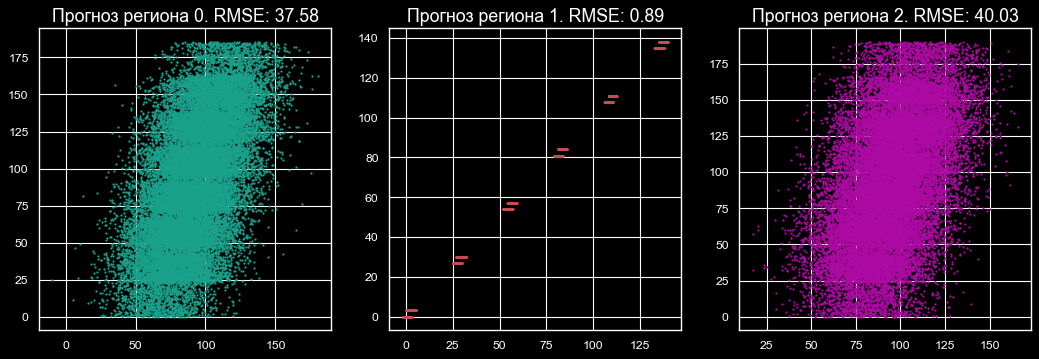

In [15]:
# Выведем на графике
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(16,5), dpi= 80)
    color = [[[0.1, 0.63, 0.55]], 'r', '#ad09a3']
    for i in range(3):
        plt.subplot(1,3,i+1)
        x = samples['proba_geo_data_'+str(i)]
        y = samples['target_geo_data_'+str(i)]
        plt.title('Прогноз региона {}. RMSE: {:.2f}'.format(i, get_rmse(y, x)), fontsize = 16)
        #plt.legend(title = 'RMSE: {:.2f}'.format(get_rmse(y, x)), fontsize = 30)
        plt.scatter(x, y, c = color[i], s = 1)
plt.show()

In [16]:
# содержимое словаря samples 
samples.keys()

dict_keys(['target_geo_data_0', 'proba_geo_data_0', 'target_geo_data_1', 'proba_geo_data_1', 'target_geo_data_2', 'proba_geo_data_2'])

## Вывод <a id="result_2"></a>
Средний запас сырья выше в регионах 0 и 2, но обучение модели на имеющихся данных прошло весьма посредственно. RMSE очень высокий, соответственно отклонения от предсказаний могут составлять до 40 едениц. Регион 1 имеет неплохо предсказывающую модель с отклонениями всего до 0,89. Следует учесть, что такой результат получился благодаря сильно коррелирующему признаку в обучающей выборке.

# 3. Подготовка к расчёту прибыли<a id="Preparing_calculation"></a>

## Сохранение всех ключевых значений для расчётов в отдельные переменные<a id="def_profit"></a> 

- Бюджет на разработку:10 000 000 000.  Из условия.
- Доход с каждой единицы продукта: 450 000.  Из условия.
- Точек исследований при разведке одного региона: 500. Из условия.
- Количество лучших точек для расчёта прибыли: 200. Из условия.
- Достаточный объём сырья для безубыточной разработки новой скважины: Бюджет / Количество точек для расчёта прибыли / Доход с каждой единицы продукта


In [17]:
# Бюджет на разработку скважин в регионе
BUGET = 1e10
# Доход с каждой единицы продукта составляет
REVENUE_PER_UNIT = 45e4
# исследований при разведке одного региона
AMOUNT_RESEARCH = 500
# количество лучших для расчёта прибыли
TOP_AMOUNT_RESEARCH = 200

## Расчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение. <a id="calc"></a>

In [18]:
# Достаточный объём сырья для безубыточной разработки новой скважины 
breakeven_volume = BUGET/REVENUE_PER_UNIT/TOP_AMOUNT_RESEARCH

print('минимальное среднее количество продукта в месторождениях региона, достаточное для разработки' ,breakeven_volume)


минимальное среднее количество продукта в месторождениях региона, достаточное для разработки 111.11111111111111


In [19]:
# Сравнение полученного объёма сырья со средним запасом в каждом регионе
mean_list = []
print('Безубыточный объем скважины: {:.2f}'.format(breakeven_volume))
for i in range(3):
    region = 'target_geo_data_'+str(i)
    mean_region = samples[region].mean()
    mean_list.append([region, mean_region, breakeven_volume])
    if breakeven_volume > mean_region:
        print('   Больше среднего по региону {}: {:.2f}'.format(i, mean_region))
    else:
        print('   Меньше среднего по региону {}: {:.2f}'.format(i, mean_region))
mean_list = pd.DataFrame(mean_list, columns = ['region', 'mean_volume', 'breakeven_volume']) 

Безубыточный объем скважины: 111.11
   Больше среднего по региону 0: 92.08
   Больше среднего по региону 1: 68.72
   Больше среднего по региону 2: 94.88


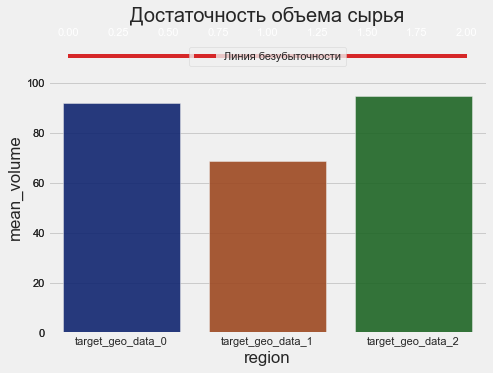

In [20]:
with plt.style.context('fivethirtyeight'):
    fig, ax1 = plt.subplots(1,1,figsize=(7,5))
    ax1.set_title('Достаточность объема сырья', fontsize=20)
    sns.barplot(data=mean_list, x="region", y="mean_volume", palette="dark", alpha=.9, ax = ax1)
    ax2 = ax1.twiny()
    mean_list.plot(y = 'breakeven_volume', color='tab:red', label = 'Линия безубыточности', ax = ax2)
    ax2.legend(loc = 'upper center')
    ax2.grid(None)
    ax2.tick_params(axis='x',rotation=0, labelcolor='white')



## Вывод <a id="result_3"></a>
В среднем по регионам объем скважин убыточен. `Регион 1` с наименьшим средним запасом сырья

# 4. Расчёт прибыли и рисков <a id="profit"></a>

## Функция расчета прибыли <a id="def_profit"></a>

In [21]:
# Расчет выручки
def get_revenue(target, probabilities, count):
            # Сортируем выборку в топ
    probs_sorted = probabilities.sort_values(ascending=False)
            # Выбираем лучшие соответствующие им настоящие значения
    selected = target[probs_sorted.index][:count]
            # Считаем выручку
    revenue = REVENUE_PER_UNIT * selected.sum()
    return revenue

In [22]:
# чтобы найти распределение прибыл, применим технику Bootstrap с 1000 выборок

def calculation_revenue_loss(target, probabilities):
    state = np.random.RandomState(12345)
    revenue = []
                            # Bootstrap
    for i in range(1000):    # 1000 выборок 
                            # выбираем 500 точек с перезаписью
        subsample = probabilities.sample(AMOUNT_RESEARCH, replace=True, random_state = state)
                            # добавляем в список посчитанную прибыль от 200 (TOP_AMOUNT_RESEARCH) лучших точек
        revenue.append(get_revenue(target, subsample, TOP_AMOUNT_RESEARCH))
                            # выручка региона    
    revenue = pd.Series(revenue)
                            # Средняя валовая прибыль региона
    gross_profit = revenue - BUGET
                            # доверительный интервал   
    lower = gross_profit.quantile(.025)
    upper = gross_profit.quantile(.975)
                            # находим процент убыточных точек: количество отрицательных точек делим на общее количество.
    loss = (gross_profit < 0).sum()/len(gross_profit)
                            # печать результатов
    #print("Средняя выручка региона:", revenue.mean())
    print("Средняя валовая прибыль региона:", gross_profit.mean())
    print("95%-ый доверительный интервал:", lower, upper)
    print("Риск убытка: {:.2%}".format(loss))
    return gross_profit.mean(), loss

## Расчёт<a id="profit_loss"></a>

======  регион 0   ======
Средняя валовая прибыль региона: 396164984.8023711
95%-ый доверительный интервал: -111215545.89049526 909766941.5534225
Риск убытка: 6.90%
======  регион 1   ======
Средняя валовая прибыль региона: 456045105.7866609
95%-ый доверительный интервал: 33820509.39898549 852289453.866036
Риск убытка: 1.50%
======  регион 2   ======
Средняя валовая прибыль региона: 404403866.56835675
95%-ый доверительный интервал: -163350413.39559925 950359574.9237995
Риск убытка: 7.60%


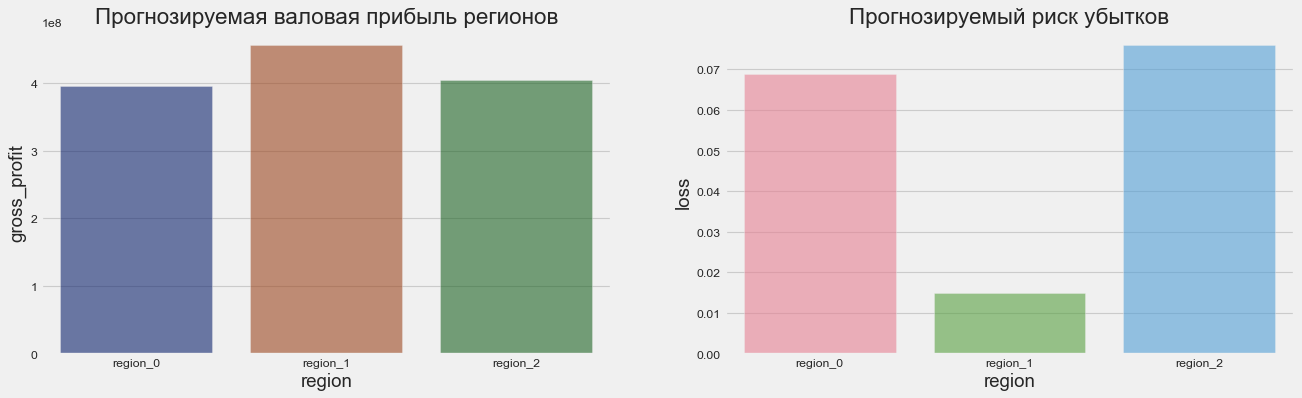

In [23]:
profit_loss = []
for i in range(3):
    print('======  регион', i, '  ======')
    probabilities = samples['proba_geo_data_'+str(i)]
    target = samples['target_geo_data_'+str(i)]
    revenue, loss = calculation_revenue_loss(target, probabilities)
    profit_loss.append(['region_'+str(i), revenue, loss])
profit_loss = pd.DataFrame(profit_loss, columns = ['region', 'gross_profit', 'loss'])    

# Отобразим на графиках
with plt.style.context('fivethirtyeight'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), dpi = 80)
    sns.barplot(data=profit_loss, x="region", y="gross_profit", palette="dark", alpha=.6, ax = ax1)
    ax1.set_title('Прогнозируемая валовая прибыль регионов')
    sns.barplot(data=profit_loss, x="region", y="loss", palette="husl", alpha=.6, ax = ax2)
    ax2.set_title('Прогнозируемый риск убытков')
    plt.show()
    #379620315.1479725, 412709654.45676965

## Вывод <a id="result_4"></a>
`1 регион` имеет вероятность убытков меньше 2.5%. По условию этого достаточно для определения региона разработки месторождения.
`Регион 0` и `Регион 2` имеют меньшую прибыль, больший риск убытков и плохие предсказывающие модели.

Предложен `1 регион` для разработки месторождения.

# 5. Подведение итогов<a id="result"></a>


- **Краткий обзор проведённой работы.** 

Данные из файлов `csv` были загруженыв словарь `geo_data` для удобства итерации. В таблицах был отброшен столбец `id`, который не влияет на обучаемость. 

Проведен предварительный обзор и анализ данных. 

Путем итерации по словарю `geo_data`, в  каждом регионе был выделен целевой признак и все данные были разбиты на обучающую и валидационную выборки. Обучена модель - `линейная регрессия`, сделаны предсказания по валидационной выборке. Предсказания и реальные данные целевого признака были записаны в словарь `samples` по названиям регионов, напечатаны предсказания среднего объема скважины, корень квадратичной ошибки прогноза модели. Построен график.

Сохранили все данные из условия в переменные, рассчитали достаточный объём сырья для безубыточной разработки новой скважины, сравнили с реальными средними показателями в регионах, вывели на экран, построили график. 

Написаны функции расчета прибыли и расчета прибыли техникой  Bootstrap и риска убытков. Путем итерации по прогнозируемым выборкам в словаре `samples` в каждом регионе посчитаны валовая прибыль, 95%-ый доверительный интервал, риск убытка в процентах. Все выведено на экран, построены графики прогнозируемой валовой прибыли и возможных убытков.

- **Главные выводы.** 

Предварительный анализ выявил корреляцию признака `f2` к целевому признаку. В `регионе 1` это почти полная зависимость. 

По имеющимся данным хорошо обучилась модель только `региона 1`, где самый низкий прогнозируемый объем сырья.

По всем регионам реальный средний объем скважин убыточен. `Регион 1` с наименьшим средним запасом сырья.

`Регион 1` имеет вероятность убытков меньше 2.5% и имеет наибольшую прогнозируемую прибыль.

#### `Регион 1` предложен для разработки месторождения.
